<a href="https://colab.research.google.com/github/claudeshyaka/master-project-repo/blob/main/Generating_Simulation_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generate Data

In [1]:
!pip install -q simbench pandapower

## Load Grid Network from Simbench

In [12]:
import simbench as sb


# Load in the grid data
grid_code = "1-HV-urban--0-sw"
net = sb.get_simbench_net(grid_code)
profiles = sb.get_absolute_values(net, profiles_instead_of_study_cases=True)

print(profiles.keys())
print(net)

/usr/local/lib/python3.10/dist-packages/simbench/converter/auxiliary.py:119: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df = pd.concat(dfs, axis=0, **kwargs)


dict_keys([('load', 'p_mw'), ('load', 'q_mvar'), ('sgen', 'p_mw'), ('gen', 'p_mw'), ('storage', 'p_mw')])
This pandapower network includes the following parameter tables:
   - bus (372 element)
   - load (79 element)
   - sgen (98 element)
   - switch (498 element)
   - ext_grid (1 elements)
   - line (113 element)
   - trafo (3 element)
   - measurement (1122 element)
   - bus_geodata (372 element)
   - substation (14 element)
   - loadcases (6 element)


## Extract Load and Static Generator Profiles

In [13]:
# Extract the loads and gen profiles
load_p = profiles[("load", "p_mw")]
load_q = profiles[("load", "q_mvar")]
sgen_p = profiles[("sgen", "p_mw")]

## Visualize the Profiles

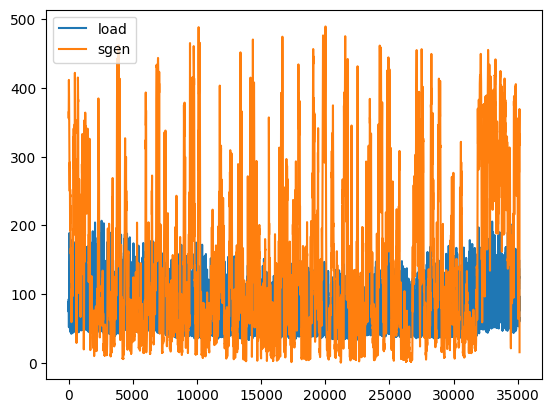

In [14]:
# Visualize the loads and gen profiles overtime
import matplotlib.pyplot as plt

load_p.sum(axis=1).plot(label="load")
sgen_p.sum(axis=1).plot(label="sgen")
plt.legend()
plt.show()

In [5]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Create PandaPower Controller for the Profiles

In [15]:
import pandapower.timeseries as ts
from pandapower.control.controller.const_control import ConstControl
from pandapower.timeseries.data_sources.frame_data import DFData

ds = DFData(sgen_p)
ConstControl(net, "sgen", "p_mw", element_index=net.sgen.index,
             profile_name=sgen_p.columns, data_source=ds)
ds = DFData(load_p)
ConstControl(net, "load", "p_mw", element_index=net.load.index,
             profile_name=load_p.columns, data_source=ds)
ds = DFData(load_q)
ConstControl(net, "load", "q_mvar", element_index=net.load.index,
             profile_name=load_q.columns, data_source=ds)
ds.df.shape

(35136, 79)

## Create a an Output Writer to Save Results of Time Series PowerFlow

In [16]:
from pandapower.timeseries import OutputWriter

def create_output_writer(net, time_steps, output_dir):
    ow = OutputWriter(net, time_steps, output_path=output_dir,
                      output_file_type=".xlsx", log_variables=list())
    # these variables are saved to the harddisk after / during the time series loop
    ow.log_variable('res_bus', 'vm_pu')
    ow.log_variable('res_bus', 'p_mw')
    ow.log_variable('res_bus', 'q_mvar')

    return ow

In [17]:
import os
import shutil
import numpy as np
import pandas as pd
import tempfile
import random
import pandapower as pp

random.seed(10)

output_dir = os.path.join("/content/drive/MyDrive/datasource",
                          "time_series_w_sgen")
print("Results can be found in your local temp folder: {}".format(output_dir))
if not os.path.exists(output_dir):
  os.mkdir(output_dir)
# else:
#   try:
#     shutil.rmtree(output_dir)
#     print('Folder and its content cleared.')
#   except:
#     print('Folder not deleted')

Results can be found in your local temp folder: /content/drive/MyDrive/datasource/time_series_w_sgen


## Run Time Series PowerFlow

In [18]:
# time steps to be calculated. Could also be a list with non-consecutive time steps
time_steps = range(0, ds.df.shape[0])

# the output writer with the desired results to be stored to files.
ow = create_output_writer(net, time_steps, output_dir=output_dir)

# the main time series function
ts.run_time_series.run_timeseries(net)

100%|██████████| 35136/35136 [24:28<00:00, 23.93it/s]


In [19]:
net.res_bus.head()

,vm_pu,va_degree,p_mw,q_mvar
0,1.068,0.0,-50.072983,133.650883
1,1.068,0.0,0.000000,0.000000
2,1.068,0.0,0.000000,0.000000
3,1.068,0.0,0.000000,0.000000
4,1.068,0.0,0.000000,0.000000


In [20]:
net.res_bus.tail()

,vm_pu,va_degree,p_mw,q_mvar
367,1.085829,-0.422296,0.0,0.0
368,1.085829,-0.422296,0.0,0.0
369,1.085829,-0.422296,0.0,0.0
370,1.085829,-0.422296,0.0,0.0
371,1.085829,-0.422296,0.0,0.0
